In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import Image, display, clear_output
from ipywidgets import widgets, Layout
from bokeh.plotting import *
import holoviews as hv

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer

import spacy
from spacy.util import minibatch, compounding
from spacy import displacy
from spacy.lang.en import English

import string
import nltk
from nltk.classify import SklearnClassifier
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

import base64
import re
from collections import Counter
import tabulate
#from tabulate import tabulate

from pathlib import Path
import copy

from wordcloud import WordCloud
from time import time
parser = English()
sns.set_context("talk")

In [2]:
episodes= ["SW_EpisodeIV.txt","SW_EpisodeV.txt", "SW_EpisodeVI.txt"]
SW= []
star_all = pd.DataFrame()
for episode in episodes:
    star_1 = pd.read_csv(episode, sep='" "', engine='python')
    star_1 = star_1.loc[:,star_1.dtypes==object].apply(lambda star_1:star_1.str.replace('"', ""))
    star_1 = star_1.reset_index(drop=True)
    star_1.columns = ['character', 'dialogue']
    SW.append(star_1)
star_all = pd.concat(SW)
star_all = star_all.reset_index(drop=True)
star_all.shape

(2523, 2)

In [3]:
pd.set_option('display.max_colwidth', -1)

In [4]:
star_all[500:507]

,character,dialogue
500,HAN,It's too big to be a space station.
501,LUKE,I have a very bad feeling about this.
502,BEN,Turn the ship around!
503,HAN,"Yeah, I think your right. Full reverse! Chewie, lock in the auxiliary power."
504,LUKE,Why are we still moving towards it?
505,HAN,We're caught in a tractor beam! It's pulling us in!
506,LUKE,But there's gotta be something you can do!


In [6]:
star_all.character.value_counts()

LUKE                      494
HAN                       459
THREEPIO                  301
LEIA                      227
VADER                     140
BEN                       115
LANDO                     101
YODA                      49 
EMPEROR                   44 
RED LEADER                38 
BIGGS                     34 
WEDGE                     33 
PIETT                     31 
TARKIN                    28 
JABBA                     26 
OWEN                      25 
CREATURE                  22 
TROOPER                   19 
ACKBAR                    14 
GOLD LEADER               14 
RIEEKAN                   13 
OFFICER                   13 
COMMANDER                 10 
RED TEN                   8  
CONTROLLER                8  
INTERCOM VOICE            8  
DECK OFFICER              7  
GOLD FIVE                 7  
BOUSHH                    7  
VEERS                     7  
                         ..  
CHIEF PILOT               1  
CONTROL OFFICER           1  
HAN and LU

In [7]:
classes=star_all.character.value_counts()
classes_big=classes[classes>=40]
sufficient=star_all[star_all.character.isin(classes_big.index)][["character",'dialogue']]

In [8]:
sufficient.character.value_counts()

LUKE        494
HAN         459
THREEPIO    301
LEIA        227
VADER       140
BEN         115
LANDO       101
YODA        49 
EMPEROR     44 
Name: character, dtype: int64

In [9]:
sufficient=sufficient.reset_index(drop=True)
sufficient.shape

(1930, 2)

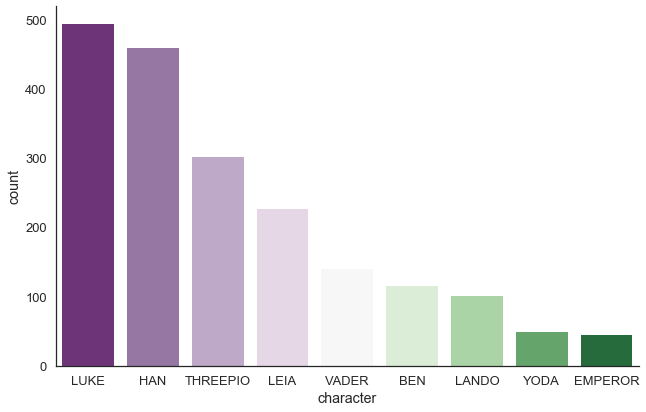

In [10]:
sns.set(style="white")
sns.set_context("talk")
g = sns.factorplot(x="character", data=sufficient, kind="count",
                   palette="PRGn", size=6, aspect=1.5, order=list(sufficient.character.value_counts().index))

In [11]:
sufficient["tokens"]=sufficient['dialogue'].apply(word_tokenize) 

In [12]:
def no_punct(tokens):
    words = [word for word in tokens if word.isalpha()]
    return words
def to_lower(tokens):
    words = [w.lower() for w in tokens]
    return words

In [13]:
sufficient["tokens"]=sufficient['tokens'].apply(to_lower)
sufficient["tokens"]=sufficient['tokens'].apply(no_punct)

In [14]:
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation

def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [15]:
clean_uniques={}
for person in sufficient.character.unique():
    INFO_text = [text for text in sufficient[sufficient['character'] == person]['dialogue']]
    INFO_clean = cleanup_text(INFO_text)
    INFO_clean = ' '.join(INFO_clean).split()
    clean_uniques[person]=set(INFO_clean)

In [16]:
sns.set(style="white")
sns.set_context('talk')
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation+"..."

def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

INFO_text = [text for text in sufficient[sufficient['character'] == 'LUKE']['dialogue']]

INFO_clean = cleanup_text(INFO_text)
INFO_clean = ' '.join(INFO_clean).split()


INFO_counts = Counter(INFO_clean)

INFO_common_words = [word[0] for word in INFO_counts.most_common(20)]
INFO_common_counts = [word[1] for word in INFO_counts.most_common(20)]



In [17]:
sns.set(style="white")
sns.set_context("talk")

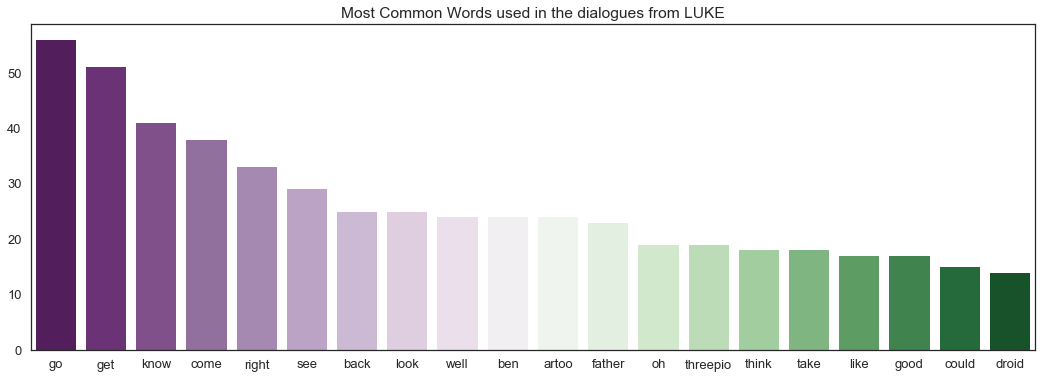

In [18]:
fig = plt.figure(figsize=(18,6))
sns.barplot(x=INFO_common_words, y=INFO_common_counts, palette="PRGn")
plt.title('Most Common Words used in the dialogues from LUKE');

In [19]:
HANtext = sufficient[sufficient['character'] == 'HAN']
HANstext = ' '.join(text for text in HANtext['dialogue'])
print('Number of words in eap_text:', len(HANstext))

Number of words in eap_text: 23023


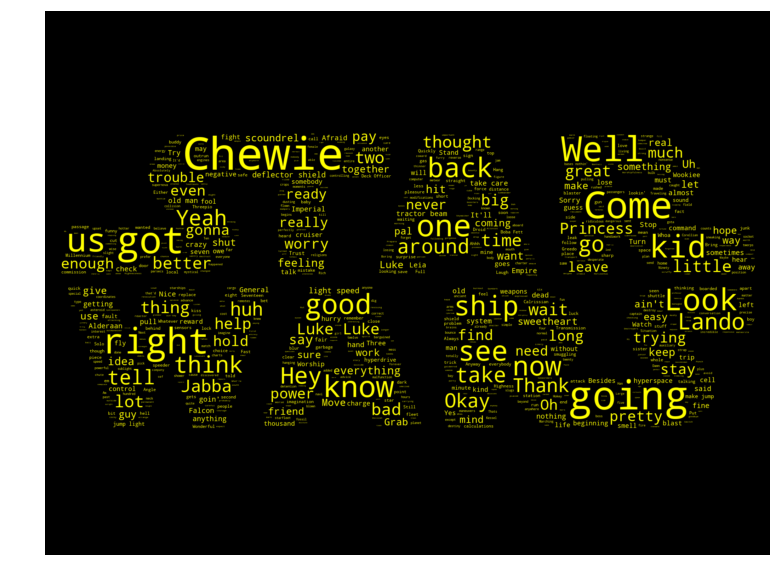

In [20]:
import numpy as np
from PIL import Image
from os import path
import matplotlib.pyplot as plt
import os
import random

from wordcloud import WordCloud, STOPWORDS

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

mask = np.array(Image.open(path.join(d, "swfilled3.png")))


text = HANstext

# pre-processing the text a little bit
text = text.replace("HAN", "Han")
text = text.replace("LUKE'S", "Luke")

# adding movie script specific stopwords
stopwords = set(STOPWORDS)
stopwords.add("int")
stopwords.add("ext")

wc = WordCloud(max_words=1000, mask=mask, stopwords=stopwords, margin=10,
               random_state=1, prefer_horizontal=1.0, color_func=lambda *args, **kwargs: "yellow").generate(text)
# store default colored image
default_colors = wc.to_array()

#wc.to_file("a_new_hope.png")
plt.figure(figsize=(20,10))
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
plt.show()

In [21]:
sufficient["words"]=sufficient.tokens.apply(lambda x: len(x))

# Who tends to hold monologues?

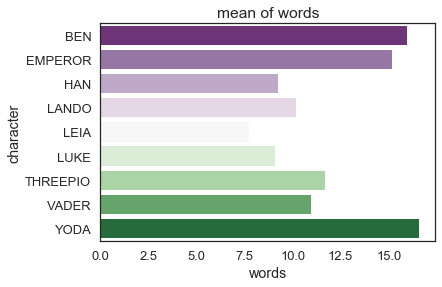

In [22]:
df = sufficient.groupby(['character'])[["words"]].mean()
ax=sns.barplot(x=df.words, y=df.index, palette="PRGn")
ax.set_title("mean of words");

In [23]:
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation

def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [24]:
clean_uniques={}
for person in sufficient.character.unique():
    INFO_text = [text for text in sufficient[sufficient['character'] == person]['dialogue']]
    INFO_clean = cleanup_text(INFO_text)
    INFO_clean = ' '.join(INFO_clean).split()
    clean_uniques[person]=set(INFO_clean)

In [25]:
star_chord=pd.DataFrame(columns=['source','target','value'])


In [26]:
persons_already=[]
for person in sufficient.character.unique():
    persons_already.append(person)
    for person2 in sufficient.character.unique():
        INTERSECT= len(clean_uniques[person].intersection(clean_uniques[person2])) 
        if not person2 in persons_already:
            star_chord = star_chord.append({'source': person, 'target': person2, 'value':INTERSECT}, ignore_index=True)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
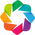

In [27]:
hv.extension('bokeh')
%output size=200

In [28]:
unique_characters=pd.DataFrame({"name":sufficient.character.unique()})
dict_characters=unique_characters.to_dict()["name"]
dict_charact={y:x for x,y in dict_characters.items()}

In [29]:
star_chord["source"]=star_chord["source"].map(dict_charact)#macht aus namen der character nummern
star_chord["target"]=star_chord["target"].map(dict_charact)#namen werden dann in nodes gespeichert

In [30]:
links = star_chord
links["value"]=pd.to_numeric(links["value"])

In [31]:
nodes = hv.Dataset(unique_characters, 'index')

In [32]:
output_notebook()

Loading BokehJS ...

# Who uses similar words?

In [33]:
%%opts Chord [label_index='name' color_index='index' edge_color_index='source'] 
%%opts Chord (cmap='Category20' edge_cmap='Category20')
hv.Chord((links, nodes)).select(value=(5, None))

:Chord   [source,target]   (value)

# spacy

In [34]:
doc = nlp('I am your father')
displacy.render(doc, style='dep', jupyter=True)

# spaCy with blank model

# spaCy with pretrained model

# using pipelines

In [35]:
y=np.array(sufficient.character.tolist())
Xnew=sufficient.tokens.apply(lambda x: ' '.join(x)) #Zusammensetzen der Tokens wieder in eine gereinigte Zeile Dialog

In [36]:
TESTNECESSARY = True
if TESTNECESSARY==True:
    X_train,X_test, y_train,  y_test = train_test_split(Xnew, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)
else:
    X_train, y_train=Xnew, y

In [37]:
mult_nb = Pipeline([("count_vectorizer", CountVectorizer()), ("multinomial nb", MultinomialNB())])

text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB())])

bern_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])

mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer( ngram_range=(1, 2))), ("multinomial nb", MultinomialNB())])

bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer( ngram_range=(1, 3))), ("bernoulli nb", BernoulliNB())])

svc_tfidf_3grams = Pipeline([("tfidf_vectorizer", TfidfVectorizer( ngram_range=(1, 3))), ("linear svc", SVC(kernel="linear"))])

svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer()), ("linear svc", SVC(kernel="sigmoid"))])

svc_tfi_chars = Pipeline([("tfidf_vectorizer", TfidfVectorizer( ngram_range=(1, 2))), ("linear svc", SVC(kernel="sigmoid"))])

sgd = Pipeline([("tfidf_vectorizer", TfidfVectorizer(ngram_range=(1, 2))),('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=0.01, random_state=42,max_iter=5, tol=None))])

sgd2 = Pipeline([("tfidf_vectorizer", TfidfVectorizer(ngram_range=(3, 10), analyzer="char")),('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=0.01, random_state=42, max_iter=5, tol=None))])

In [38]:
%%time
all_models = [
   ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc_tfidf_3grams",svc_tfidf_3grams), 
    ("svc_tfidf", svc_tfidf),
   ("svc_tfi_chars", svc_tfi_chars),
    ("sgd", sgd),
    ("sgd2", sgd2),
    ("text_clf", text_clf)]
unsorted_scores = [(name, cross_val_score(model, X_train, y_train, cv=5).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])

CPU times: user 16.7 s, sys: 522 ms, total: 17.2 s
Wall time: 17.3 s


# using pipelines

In [39]:
print (tabulate.tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

model               score
----------------  -------
sgd                0.4323
sgd2               0.4276
mult_nb            0.4121
svc_tfidf_3grams   0.4070
text_clf           0.3650
mult_nb_tfidf      0.3541
bern_nb_tfidf      0.2786
svc_tfidf          0.2562
svc_tfi_chars      0.2562
bern_nb            0.2234


In [40]:
sgd.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [41]:
sgd.predict(["I am your father"])

array(['VADER'], dtype='<U8')

In [42]:
prediction=sgd.predict(X_test)

In [43]:
X_train[X_train.str.contains('am your father')]

1342    no i am your father
Name: tokens, dtype: object

In [44]:
cm =confusion_matrix(y_test, prediction)

In [45]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm,interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [46]:
sns.set_context('talk')

# confusion matrix

Confusion matrix, without normalization


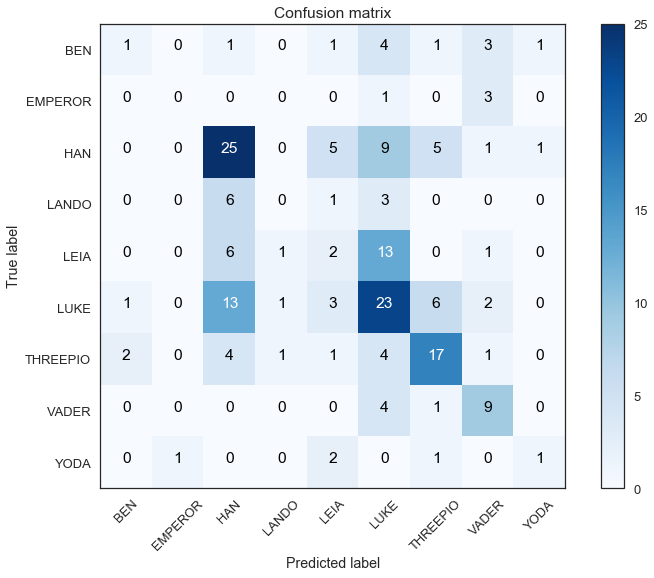

In [47]:
plot_confusion_matrix(cm, sgd.classes_, False);
plt.gcf().set_size_inches(12,12)

# confusion matrix

Normalized confusion matrix


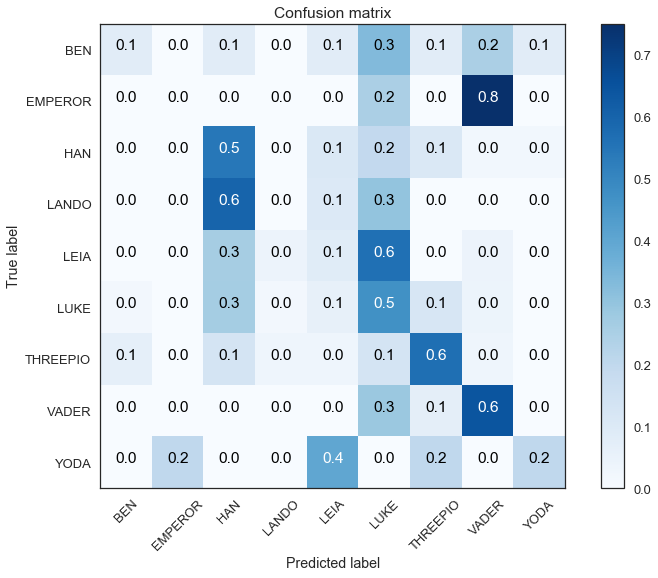

In [48]:
plot_confusion_matrix(cm, sgd.classes_, True);
plt.gcf().set_size_inches(12,12)

# evaluating predictions

In [49]:
evaldf=pd.DataFrame({'X_test': X_test, 'y_test': y_test, 'prediction': prediction})
evaldf[110:120]

,X_test,y_test,prediction
1458,you serve your master well,LUKE,THREEPIO
345,looks like we coming up on alderaan,HAN,LUKE
1057,i am not a committee,LEIA,HAN
1534,i meet you back at the fleet,LUKE,LUKE
683,hang on artoo,THREEPIO,LUKE
1807,hey do worry chewie and me got into a lot of places more heavily guarded than this,HAN,HAN
1261,over to you,HAN,THREEPIO
1199,luke i do want to lose you to the emperor the way i lost vader,BEN,VADER
1727,it against my programming to impersonate a deity,THREEPIO,LUKE
90,just luke,LUKE,LEIA
